In [1]:
import numpy as np # Linear algebra
import pandas as pd # Processing
from keras.models import Sequential # Importing sequential model from Keras for multi-label classification
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D # List of layers that will be passed to the sequential constructor
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler # Set of functions to be applied at given stages of the training procedure
import cv2 # To integrate OpenCV arrays with other libraries which use NumPy
from tqdm import tqdm # For iterations
from sklearn.metrics import fbeta_score # Weighted harmonic mean of precision and recall between 0 and 1
import plotly.graph_objs as go # For graphs and plots
import plotly.offline as py # To generate graphs as images
py.init_notebook_mode(connected=True) # To view the graphs on notebooks
import matplotlib.pyplot as plt # Module pyplot
%matplotlib inline

# Planet: Understanding the Amazon from Space
### Use satellite data to track the human footprint in the Amazon rainforest

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

### Nikitarom's Planet dataset was added for this project to be executed.
The dataset consists of the required training images, test images, additional test images, train csv and sample submission csv.

The train and sample submission csv files contain image names with their respective tags.
The training images are 40479 jpg files to be used for training and validating the model.
The test images and additional test files 40669 and 20522 jpg files respectively for testing the model. A total of 61191 jpg files for testing the model.

In [2]:
# Loading the train data
df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')

# Previewing the first five rows
df_train.head(5)

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [3]:
# Exploratory Data Analysis
# Bar-plot
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=800, width=800, title='Distribution of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-label-dist')

In [4]:
# Heatmap
htmp = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        htmp[i, i2] = cy / c

data=[go.Heatmap(z=htmp, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Heatmap of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-htmp')

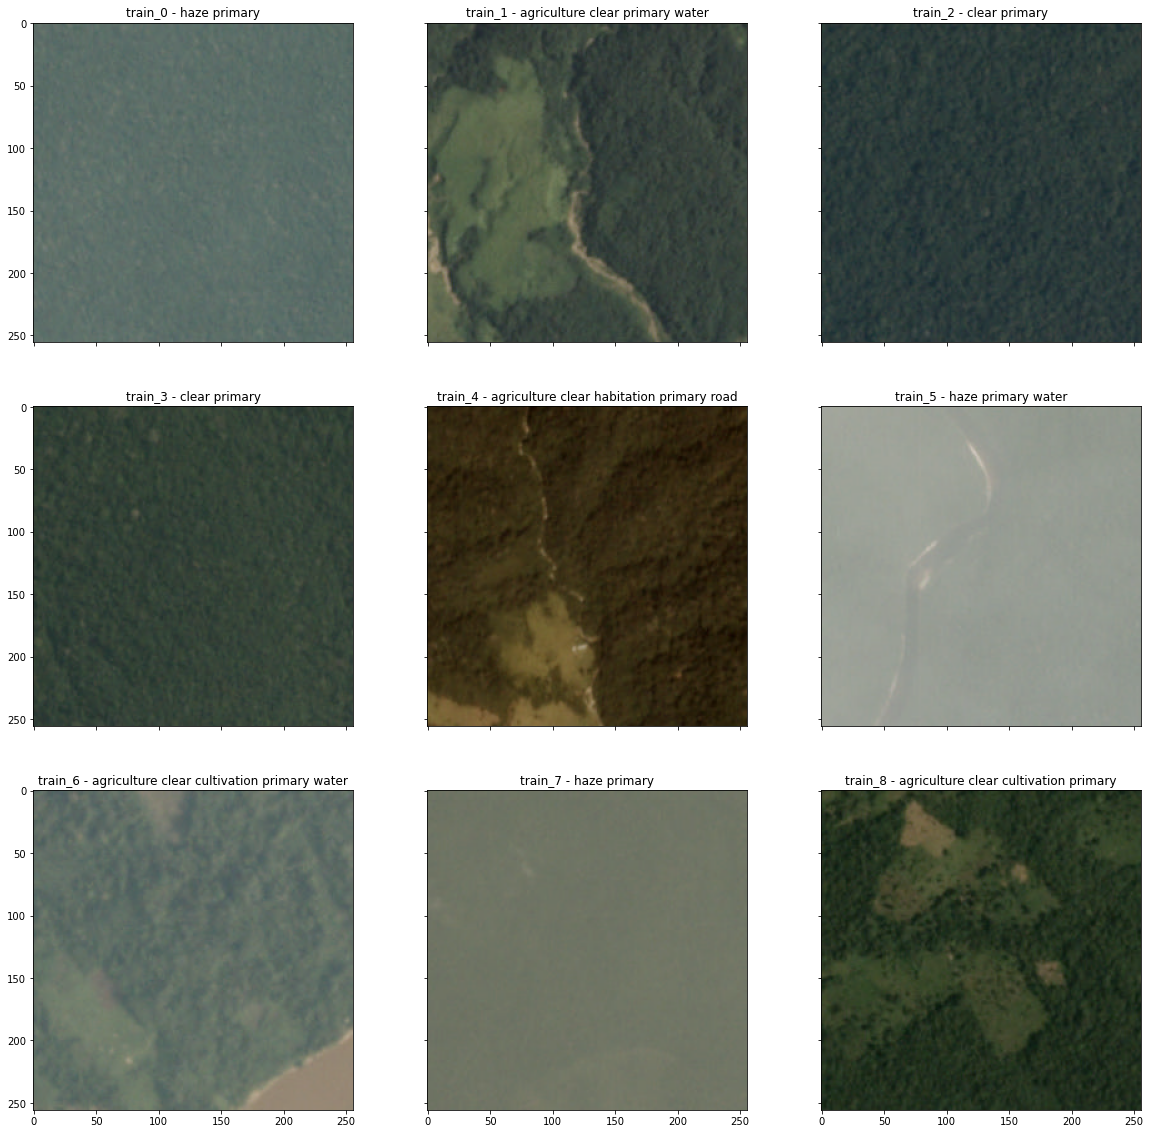

In [5]:
# Preview some images with their respective tags
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

In [6]:
# TRAINING THE MODEL
# Creating an empty list for our train images
x_train = []
y_train = []

# Obtaining unique labels from the training data
train_flatten = lambda l: [item for sublist in l for item in sublist]
train_labels = list(set(train_flatten([l.split(' ') for l in df_train['tags'].values])))
train_label_map = {l: i for i, l in enumerate(train_labels)}
inv_label_map = {i: l for l, i in train_label_map.items()}

# Appending the training images as a list
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f)) # Loading the images from the specified files
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[train_label_map[t]] = 1
    # Obtaining the features as x and target as y
    x_train.append(cv2.resize(img, (32, 32), cv2.INTER_AREA))
    y_train.append(targets)
    
# Converting the list to numpy array
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

# Checking the shapes of the converted data
print(x_train.shape)
print(y_train.shape)

# Splitting and the x and y data for training and validation
split = 35000
x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

# Instantiating the sequential models with various hyper-parameters
model = Sequential()
# Instantiating the Keras layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

# Creating epoch and learning rate for the callbacks hyperparameter
epoch = 5
lrate= 0.01

# Function for the epoch and learning rate
def my_learning_rate(epoch, lrate):
    return lrate

# Instantiating
lrs = LearningRateScheduler(my_learning_rate)

# Compiling the sequential model with loss, optimizer and metrics hyper-parameters
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
              
# Fiting the sequential model with the splitted x_train and y_train
model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(x_valid, y_valid), callbacks=[lrs])
          
# Obtaining the model's prediction and FBeta Score
p_valid = model.predict(x_valid, batch_size=128)
print(y_valid)
print(p_valid)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

100%|██████████| 40479/40479 [01:51<00:00, 364.14it/s]


(40479, 32, 32, 3)
(40479, 17)
Epoch 1/50
274/274 [==============================] - 3s 12ms/step - loss: 0.2555 - accuracy: 0.8813 - val_loss: 0.2045 - val_accuracy: 0.9463
Epoch 2/50
274/274 [==============================] - 3s 9ms/step - loss: 0.2074 - accuracy: 0.9218 - val_loss: 0.1867 - val_accuracy: 0.9292
Epoch 3/50
274/274 [==============================] - 3s 11ms/step - loss: 0.1923 - accuracy: 0.9075 - val_loss: 0.1770 - val_accuracy: 0.9239
Epoch 4/50
274/274 [==============================] - 3s 10ms/step - loss: 0.1848 - accuracy: 0.8946 - val_loss: 0.1714 - val_accuracy: 0.9164
Epoch 5/50
274/274 [==============================] - 2s 9ms/step - loss: 0.1802 - accuracy: 0.8857 - val_loss: 0.1642 - val_accuracy: 0.9108
Epoch 6/50
274/274 [==============================] - 2s 9ms/step - loss: 0.1746 - accuracy: 0.8691 - val_loss: 0.1647 - val_accuracy: 0.9159
Epoch 7/50
274/274 [==============================] - 3s 9ms/step - loss: 0.1712 - accuracy: 0.8617 - val_loss: 0.

In [7]:
# Loading the sample submission data
sample_sub = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

# Previewing the first five rows
sample_sub.head(5)

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

In [8]:
# THE TEST DATA
# Creating an empty list for each test images that are in seperate paths
test1 = []
test2 = []

# Loading the test data that are in two paths
df_test1 = sample_sub.iloc[:40669]
df_test2 = sample_sub.iloc[40669:]

# Obtaining unique labels from both test data
# Test data 1
test1_flatten = lambda l: [item for sublist in l for item in sublist]
test1_labels = list(set(test1_flatten([l.split(' ') for l in df_test1['tags'].values])))
test1_label_map = {l: i for i, l in enumerate(test1_labels)}
inv1_label_map = {i: l for l, i in test1_label_map.items()}

# Test data 2
test2_flatten = lambda l: [item for sublist in l for item in sublist]
test2_labels = list(set(test2_flatten([l.split(' ') for l in df_test2['tags'].values])))
test2_label_map = {l: i for i, l in enumerate(test2_labels)}
inv2_label_map = {i: l for l, i in test2_label_map.items()}

# Appending test images as a list
# Test image 1
for f, tags in tqdm(df_test1.values, miniters=1000):
    img1 = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f))# Loading the images from the specified files
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[test1_label_map[t]] = 1
    test1.append(cv2.resize(img1, (32, 32), cv2.INTER_AREA))
    
# Test image 2
for f, tags in tqdm(df_test2.values, miniters=1000):
    img2 = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f))# Loading the images from the specified files
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[test2_label_map[t]] = 1
    test2.append(cv2.resize(img2, (32, 32), cv2.INTER_AREA))
    
# Converting the list to numpy array
test1 = np.array(test1, np.float16) / 255.
test2 = np.array(test2, np.float16) / 255.

# Checking the shapes of the converted data
print(test1.shape)
print(test2.shape)

100%|██████████| 20522/20522 [00:53<00:00, 380.24it/s]


(40669, 32, 32, 3)
(20522, 32, 32, 3)


In [9]:
# Making predictions on the test data
pred_test1 = model.predict(test1, batch_size = 128)
pred_test2 = model.predict(test2, batch_size = 128)

In [10]:
# Converting both predictions on the test data to dataframe
df1 = pd.DataFrame(data = pred_test1)
df2 = pd.DataFrame(data = pred_test2)

# Giving labels to the columns of both dataframe
df2.columns = train_labels
df1.columns = train_labels

# Setting threshold for each respective tags to obtain multi-label classification
# Dataframe 1
preds1 = []
thres = [0.07, 0.17, 0.2, 0.04, 0.23, 0.33, 0.24, 0.22, 0.1, 0.19, 0.23, 0.24, 0.12, 0.14, 0.25, 0.26, 0.16]
for i in tqdm(range(df1.shape[0]), miniters=1000):
    a = df1.iloc[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds1.append(' '.join(list(a.index))) # appending each label greater than its respective threshold
# Dataframe 2
preds2 = []
thres = [0.07, 0.17, 0.2, 0.04, 0.23, 0.33, 0.24, 0.22, 0.1, 0.19, 0.23, 0.24, 0.12, 0.14, 0.25, 0.26, 0.16]
for i in tqdm(range(df2.shape[0]), miniters=1000):
    a = df2.iloc[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds2.append(' '.join(list(a.index))) # appending each label greater than its respective threshold
    
# Merging both dataframe to obtain the final predicted tags
preds1.extend(preds2)

# Replacing tags with final predictions in the sample submission dataframe
sample_sub['tags'] = preds1

# Saving it as a csv file for submission and grading
sample_sub.to_csv('Damiii.csv', index=False)

100%|██████████| 20522/20522 [00:47<00:00, 432.41it/s]
